# Compare real CELEX (and others) to artificial lexicons

Using the code here (https://github.com/SbllDtrch/NullLexicons) to generate artificial lexicons based on real phonotactic properties of a language. We can then compare distributional properties of the real lexicon to these artificial lexicons.

In [1]:
import src.utils as utils
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as sm

from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## English

First we investigate the English lexicon. We compare lemmas from CELEX to a number of artificially-generated lexicons, matched for the same distribution of syllable lengths.

### Real lexicon

In [3]:
df_celex_og = pd.read_csv("data/processed/english/english_all_reals.csv")
print(len(df_celex_og))

52438


In [4]:
df_celex_processed = pd.read_csv("data/processed/english/english_lemmas_processed.csv")
len(df_celex_processed)

35107

In [5]:
df_celex_og.head(5)

,Unnamed: 0,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,num_phones,num_sylls_est,log_prob,surprisal
0,0,a,4.36,1,1,ART,1,1,1,-4.543025,4.543025
1,1,a,4.37,1,1,N,1,1,1,-4.543025,4.543025
2,2,a,2.67,0,1,NaN,1,1,1,-4.543025,4.543025
3,3,A,4.37,0,1,NaN,1,1,1,-4.543025,4.543025
4,4,AA,0.48,1,11,N,2,2,2,-4.726224,4.726224


In [6]:
REAL_HOMOPHONE_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_HOMOPHONE_PERCENTAGE

0.1564360383969009

In [7]:
df_celex_processed['num_homophones'].mean()

0.19312387842880338

### Compare to null lexicon

In [8]:
# NUM_ARTIFICIAL = 10
NUM_ARTIFICIAL = 10

In [9]:
df_english_with_sims = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls_no_restriction.csv")


In [56]:
df_english_with_sims['lexicon'] = df_english_with_sims['lexicon'].apply(lambda x: str(x))

In [57]:
df_english_with_sims.head(5)

,Unnamed: 0,word,num_phones,prob,num_sylls_est,surprisal,lexicon
0,0,1fId{n,6,-7.393919,3,7.393919,0
1,1,bl{bIt1kh6nd,12,-11.819299,4,11.819299,0
2,2,k@mEnsid,8,-7.542451,3,7.542451,0
3,3,lQNh8rI,7,-6.677133,3,6.677133,0
4,4,hQr@R,5,-4.917494,2,4.917494,0


#### Phonotactics

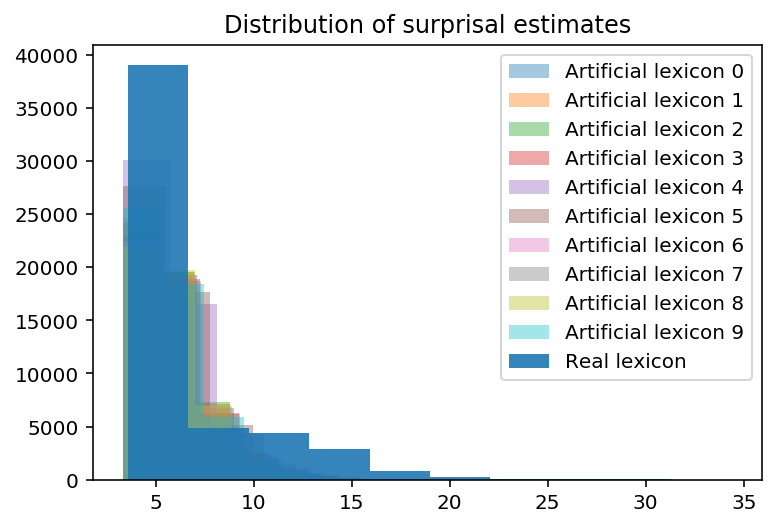

In [62]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

In [63]:
print(df_english_with_sims['surprisal'].mean())
print(df_english_with_sims['surprisal'].std())

6.001244208099965
1.724088322268973


In [64]:
print(df_celex_og['surprisal'].mean())
print(df_celex_og['surprisal'].std())

6.760057833607845
3.271802870276696


In [65]:
import seaborn as sns

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of surprisal estimates')

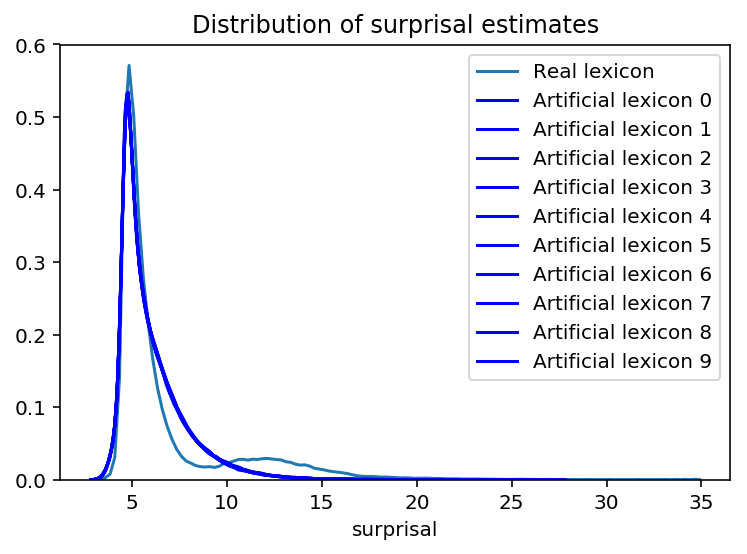

In [66]:
sns.distplot(df_celex_og['surprisal'], hist=False, label = "Real lexicon")

for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    sns.distplot(df_tmp['surprisal'], color = "blue", hist=False, label = "Artificial lexicon {x}".format(x=i))

plt.title("Distribution of surprisal estimates")


#### Lengths

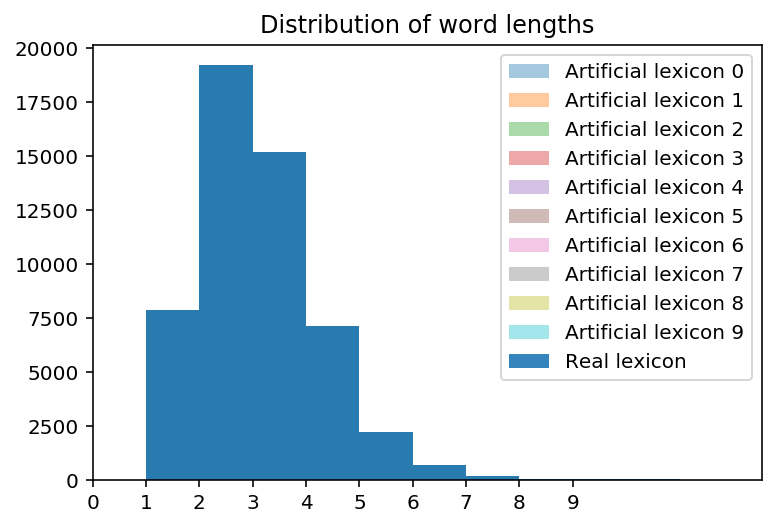

In [14]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i), bins=11)

# plt.hist(df_english_with_sims[df_english_with_sims['lexicon']=="real"]['length'], 
#          alpha = .6, label = "Real lexicon".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
          alpha = .9, label = "Real lexicon".format(x=i), bins=11)
plt.title("Distribution of word lengths")
plt.xticks(range(0, 10))
plt.legend()
plt.savefig("Figures/english/english_syll_dist.png", dpi=300)

In [15]:
from collections import Counter
Counter(df_celex_og['num_sylls_est'])

Counter({1: 7855,
         2: 19198,
         3: 15165,
         4: 7124,
         5: 2223,
         6: 670,
         7: 165,
         8: 25,
         10: 5,
         9: 7,
         12: 1})

## Homophones

### Comparing percentage, mean, and max of homophones

In [15]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


No handles with labels found to put in legend.


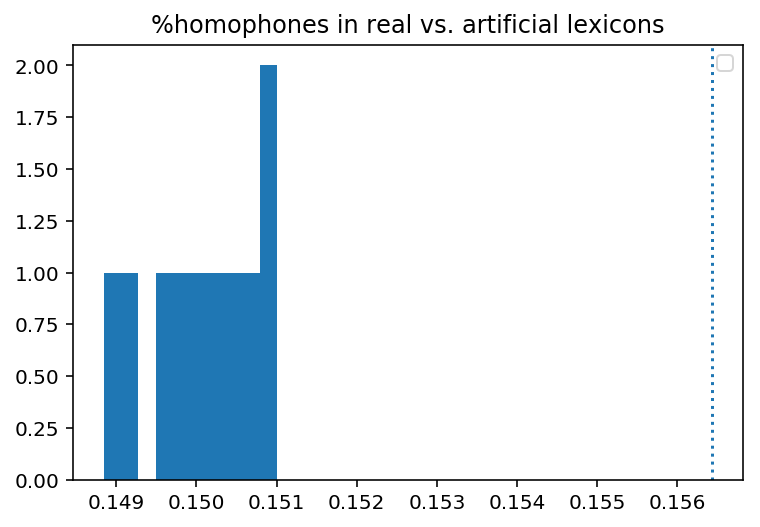

In [16]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_HOMOPHONE_PERCENTAGE, linestyle="dotted")


No handles with labels found to put in legend.


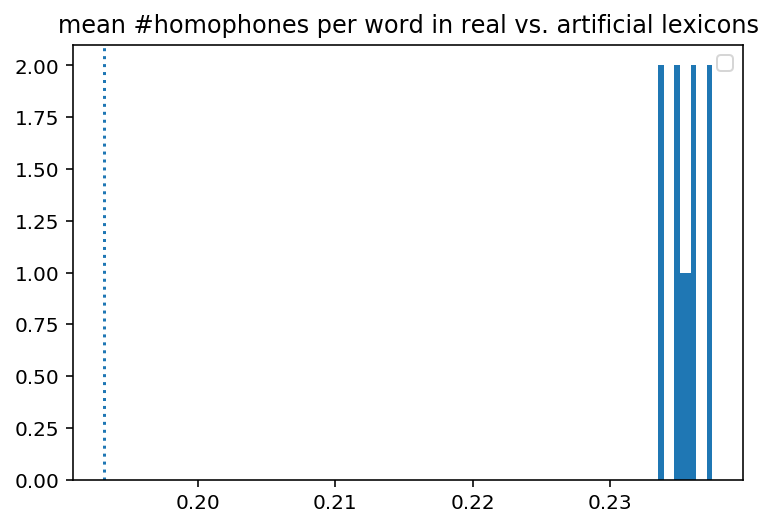

In [17]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


No handles with labels found to put in legend.


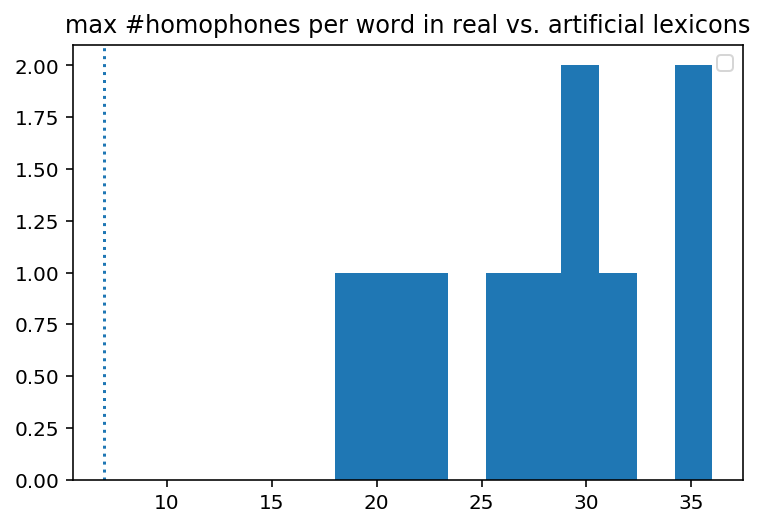

In [18]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### By syllables

In [19]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                          syl_column='num_sylls_est', 
                                          homophone_column='num_homophones')

/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


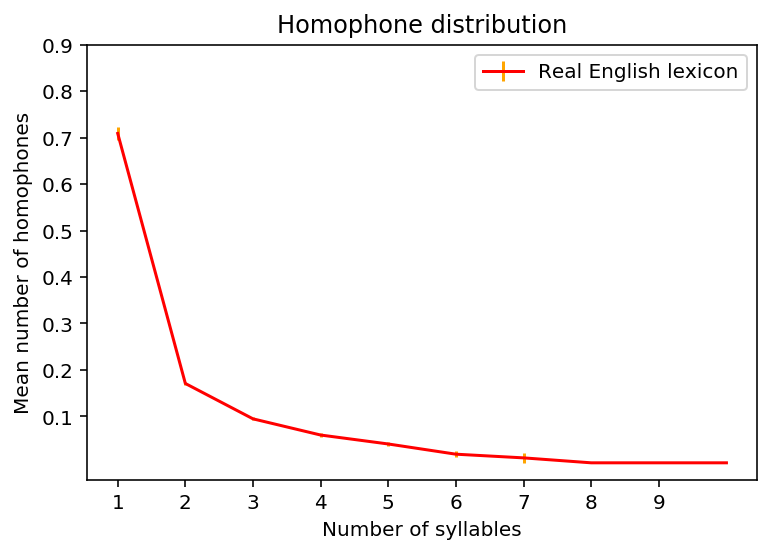

In [20]:
### First plot real
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")
plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9])
plt.legend(loc='upper right')

In [21]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

100%|██████████| 10/10 [00:00<00:00, 11.72it/s]


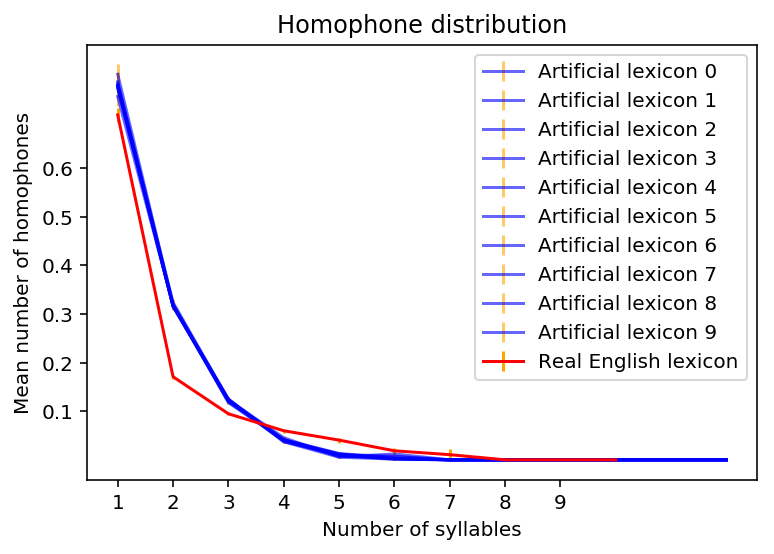

In [22]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

#### Statistics 

Interestingly, whether the **real slope** falls to the left or right of the simulated distribution appears to depend on whether **surprisal** is included as a covariate. If it is, then the **real slope** surpasses the **simulated lexicons**––e.g. above "chance". But if it's not, then it's weaker than "chance".

In [31]:
slope_coefs_english = []
surprisal_coefs_english = []
for df_tmp_processed in tqdm(processed_artificials):    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs_english.append(result.params['num_sylls_est'])
    surprisal_coefs_english.append(result.params['surprisal'])

100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


In [32]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

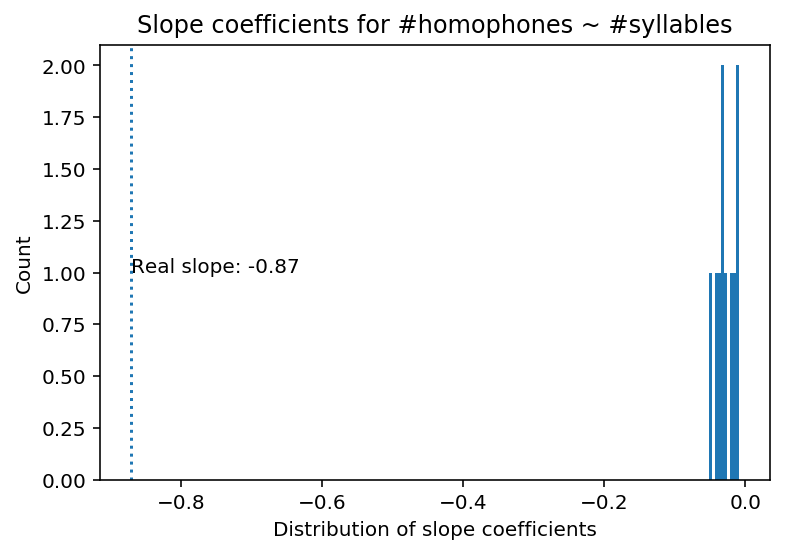

In [33]:
plt.hist(slope_coefs_english)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

In [35]:
import numpy as np
np.mean(slope_coefs_english)

-0.027341311472510593

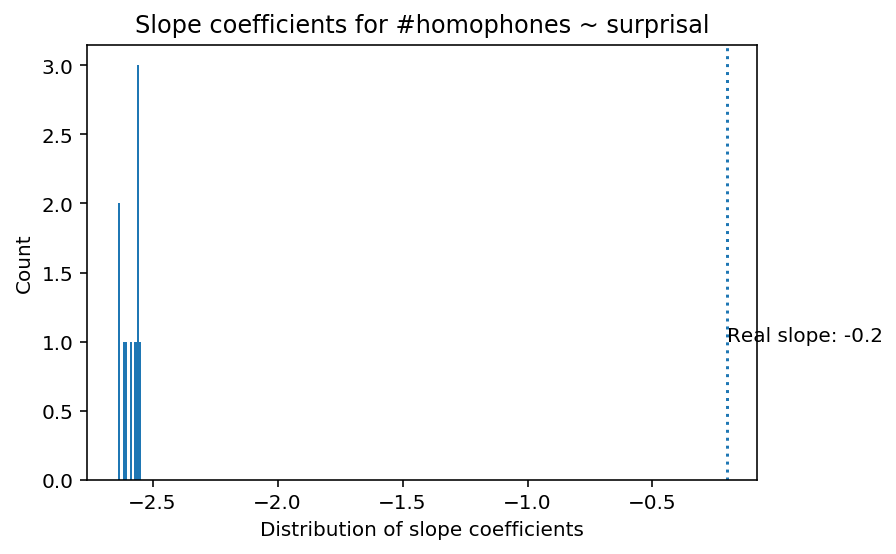

In [36]:
plt.hist(surprisal_coefs_english)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## German

### Real lexicon

In [10]:
df_celex_og = pd.read_csv("data/processed/german/german_all_reals.csv")

In [11]:
len(df_celex_og)

51719

In [12]:
df_celex_processed = pd.read_csv("data/processed/german/german_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,Word,CompCnt,PhonDISC,SylCnt,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,0,A,1,a,1,1,1,False,1,-4.700550,4.700550
1,1,1,Ae,1,),1,1,1,False,0,-4.708451,4.708451
2,2,2,aalen,1,al@n,2,4,2,False,0,-4.999407,4.999407
3,3,3,Aal,1,al,1,2,1,False,0,-4.736787,4.736787
4,4,4,aalglatt,2,algl&t,2,6,2,False,0,-6.063007,6.063007


In [13]:
len(df_celex_processed)

50474

In [14]:
REAL_GERMAN_PERCENTAGE = round(len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed),
                               2)
REAL_GERMAN_PERCENTAGE

0.02

In [15]:
df_celex_processed['num_homophones'].mean()

0.024646352577564687

### Compare to null lexicon

In [16]:
# NUM_ARTIFICIAL = 10
NUM_ARTIFICIAL = 10

In [17]:
df_german_artificials = pd.read_csv("data/processed/german/german_artificial_10_matched_on_sylls_no_restriction.csv")

In [18]:
df_german_artificials['lexicon'] = df_german_artificials['lexicon'].apply(lambda x: str(x))

In [19]:
df_german_artificials.head(5)

,Unnamed: 0,word,num_phones,prob,num_sylls_est,surprisal,lexicon
0,0,k&fef&kUl)r@n,13,-10.689884,6,10.689884,0
1,1,nOrt/lk@rbOrstfEr&nrYxIx,24,-15.962176,8,15.962176,0
2,2,demorit,7,-6.212940,3,6.212940,0
3,3,Unt@rb&lIsmUs,13,-6.699831,5,6.699831,0
4,4,tron@nm)tx@n,12,-7.397598,4,7.397598,0


In [20]:
len(df_german_artificials)

517190

#### Phonotactics

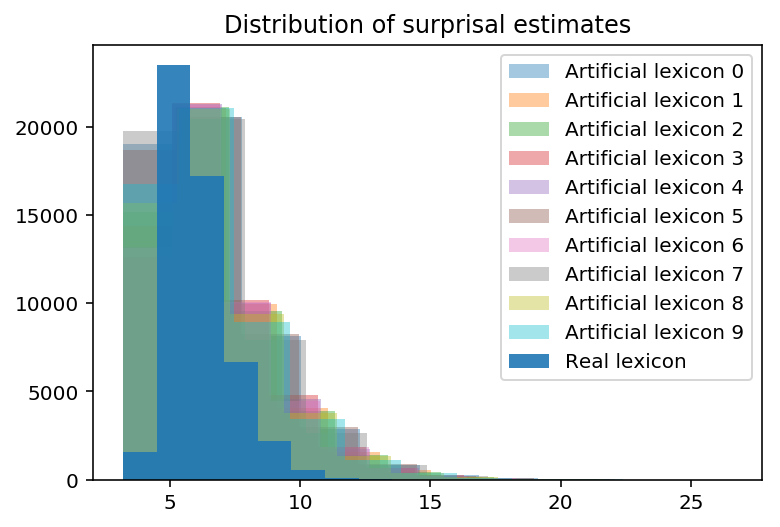

In [104]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

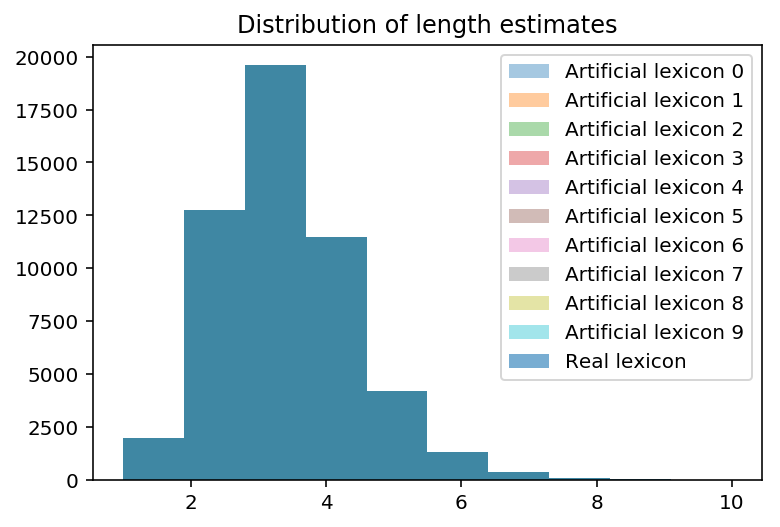

In [105]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .6, label = "Real lexicon".format(x=i))
plt.title("Distribution of length estimates")
plt.legend()

## Homophones

### Comparing percentage, mean, and max of homophones

In [24]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


No handles with labels found to put in legend.


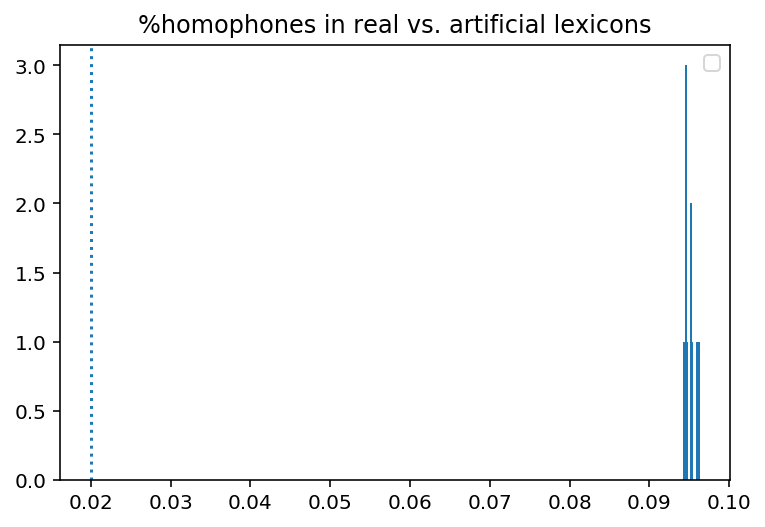

In [107]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_GERMAN_PERCENTAGE, linestyle="dotted")


No handles with labels found to put in legend.


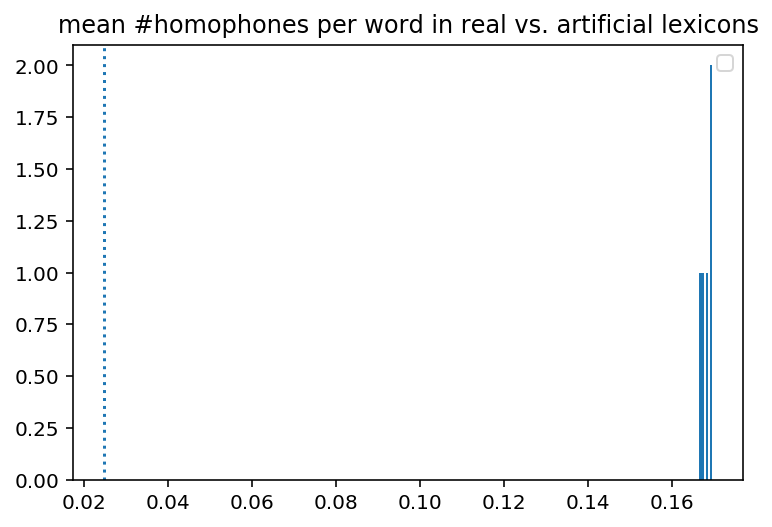

In [108]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


No handles with labels found to put in legend.


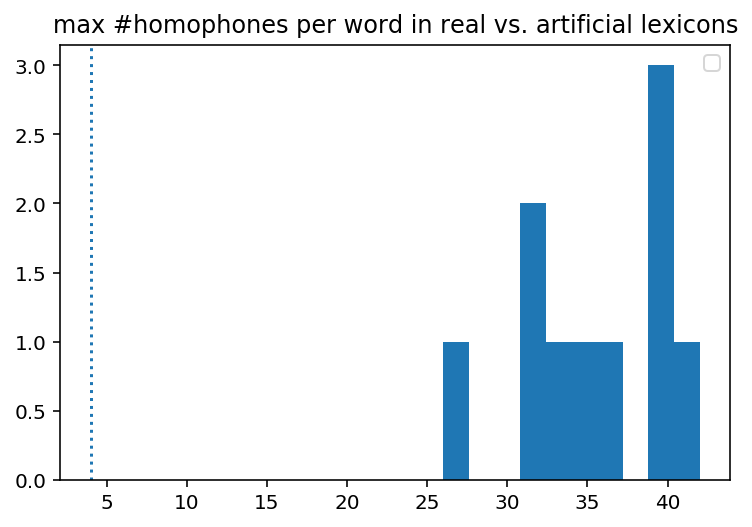

In [109]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### Distribution of homophones

In [21]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

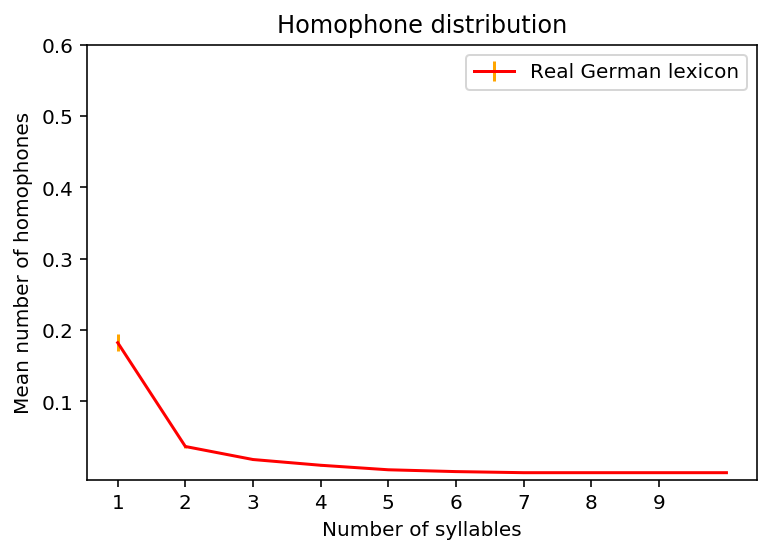

In [22]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real German lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

In [25]:
artificials = []
for df_tmp_processed in processed_artificials:
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

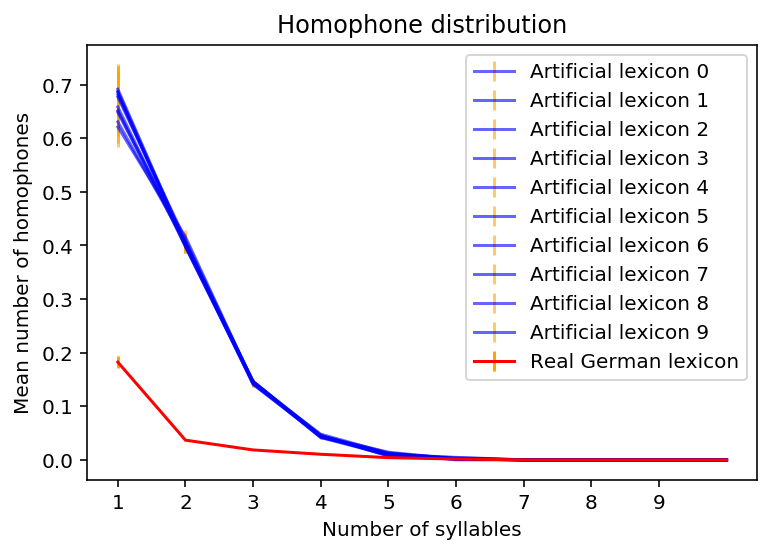

In [26]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real German lexicon")
plt.xticks(list(range(1, 10)))
#plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

### Statistics

As with English, the coefficient on **number of syllables** depends on whether **surprisal** is included. If it is, the real lexicon has a larger magnitude coefficient than the simulated ones; if not, the other way around.

In [44]:
r1 = sm.poisson(formula="num_homophones ~ num_sylls_est", 
                data=processed_artificials[0]).fit(disp=0)
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                44274
Model:                        Poisson   Df Residuals:                    44272
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Oct 2019   Pseudo R-squ.:                  0.1206
Time:                        15:29:44   Log-Likelihood:                -21605.
converged:                       True   LL-Null:                       -24569.
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8562      0.033     25.598      0.000       0.791       0.922
num_sylls_est    -0.9401      0.013    -71.423      0.000      -0.966      -0.914
=================================================================================
"""

In [114]:
slope_coefs = []
surprisal_coefs_german = []
for df_tmp_processed in tqdm(processed_artificials):    
    # df_tmp = df_tmp[df_tmp['in_celex']==False]
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_german.append(result.params['surprisal'])

100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


In [115]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = round(result_real.params['num_sylls_est'], 2)
surprisal_slope = round(result_real.params['surprisal'], 2)

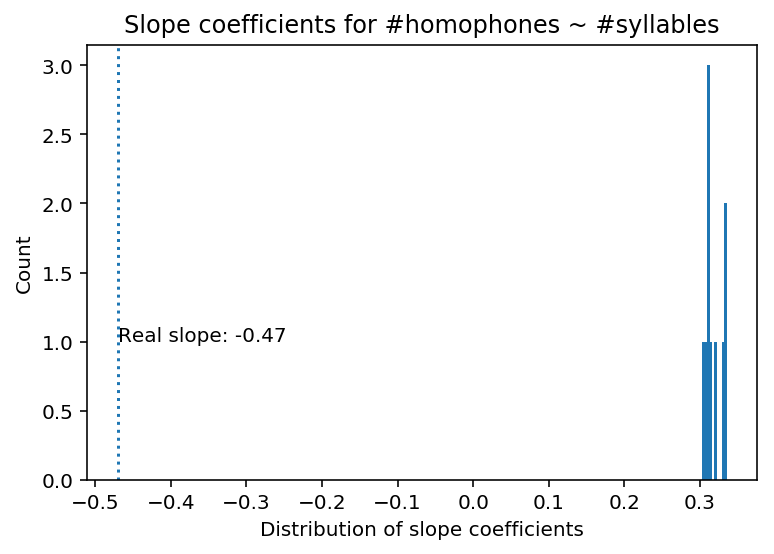

In [119]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=real_slope),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.axvline(x=0, linestyle="dashed")
# plt.legend(loc='upper right')
plt.show()

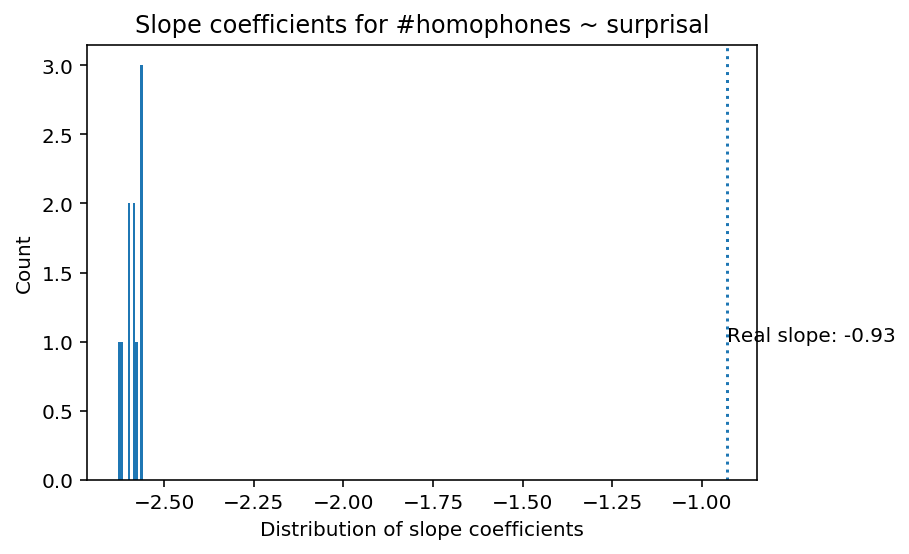

In [117]:
plt.hist(surprisal_coefs_german)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## Dutch

### Real lexicon

In [126]:
df_celex_og = pd.read_csv("data/processed/dutch/dutch_all_reals.csv")

In [127]:
len(df_celex_og)

67910

In [128]:
df_celex_processed = pd.read_csv("data/processed/dutch/dutch_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,IdNum,Word,Inl,PhonStrsDISC,PhonCVBr,PhonSylBCLX,PhonStrsStDISC,PhonStCVBr,PhonSylStBCLX,PhonolCLX,PhonolCPA,PhonDISC,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,0,1,a,1986,'a,[VV],[a:],'a,[VV],[a:],a:,a:,a,1,1,False,2,-4.811078,4.811078
1,1,5,6,aagt,0,'axt,[VVCC],[a:xt],'axt,[VVCC],[a:xt],a:xt,a:xt,axt,3,1,False,0,-4.975899,4.975899
2,2,6,7,aagtappel,0,'axt-A-p@l,[VVCC][V[C]VC],[a:xt][A[p]@l],'axt-A-p@l,[VVCC][V[C]VC],[a:xt][A[p]@l],a:xt#A-p@l,a:xt#A.p@l,axtAp@l,7,3,False,0,-7.062558,7.062558
3,3,7,8,aai,27,'aj,[VVC],[a:j],'aj,[VVC],[a:j],a:j,a:j,aj,2,1,False,0,-4.867806,4.867806
4,4,8,9,aaien,446,'a-j@,[VV][CV],[a:][j@],'aj,[VVC],[a:j],a:j,a:j,aj@,3,2,False,0,-5.018821,5.018821


In [129]:
len(df_celex_processed)

65351

In [130]:
REAL_DUTCH_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_DUTCH_PERCENTAGE

0.029242092699423114

### Compare to artificial lexicons

In [131]:
NUM_ARTIFICIAL = 10

In [132]:
df_dutch_artificial = pd.read_csv("data/processed/dutch/dutch_artificial_10_matched_on_sylls_no_restriction.csv")


In [133]:
len(df_dutch_artificial)

679100

In [134]:
df_dutch_artificial['lexicon'] = df_dutch_artificial['lexicon'].apply(lambda x: str(x))

#### Phonotactics

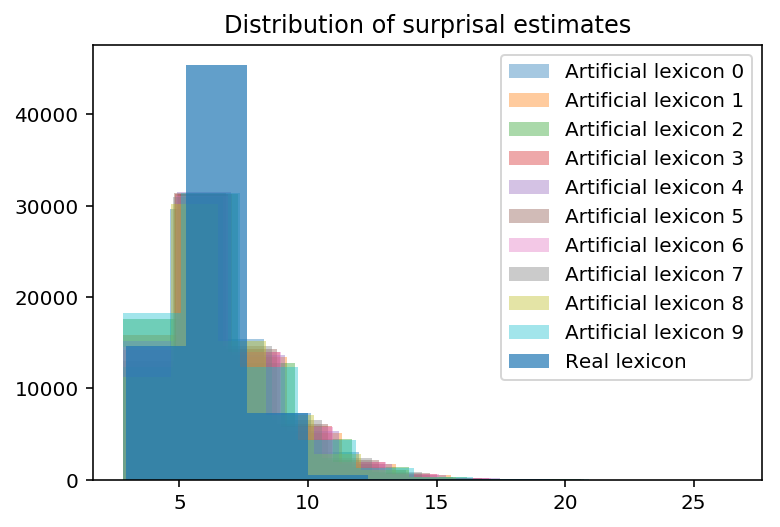

In [135]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

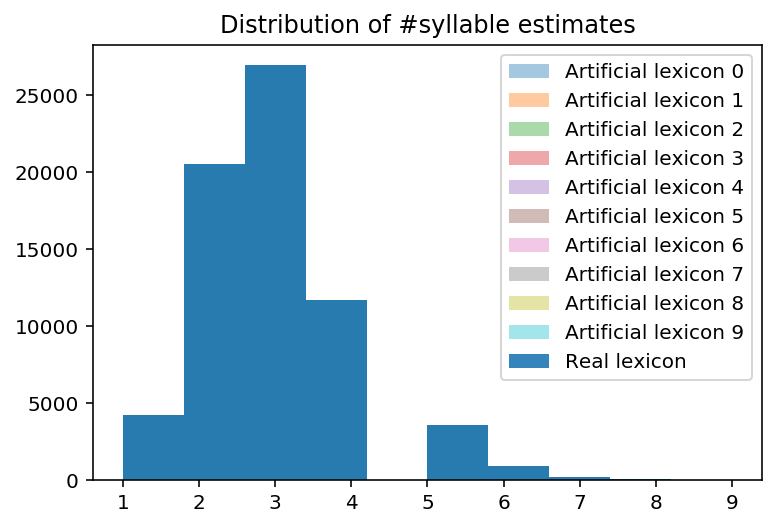

In [136]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of #syllable estimates")
plt.legend()

## Homophones

### Comparing percentage, mean, and max of homophones

In [137]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


No handles with labels found to put in legend.


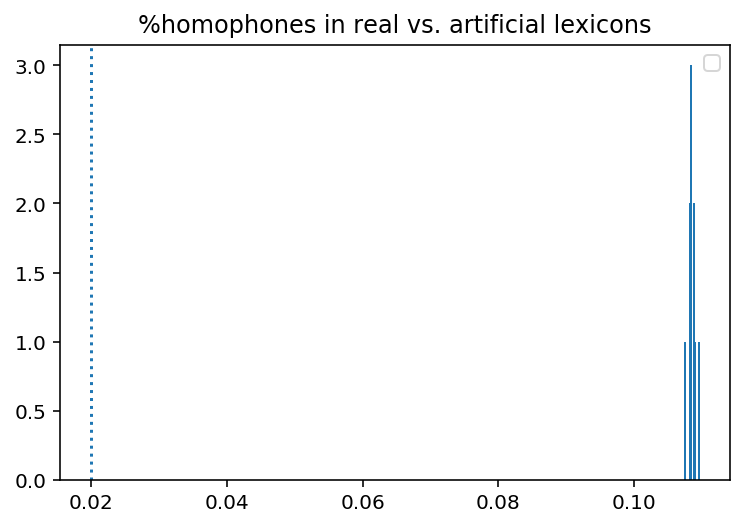

In [138]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_GERMAN_PERCENTAGE, linestyle="dotted")


No handles with labels found to put in legend.


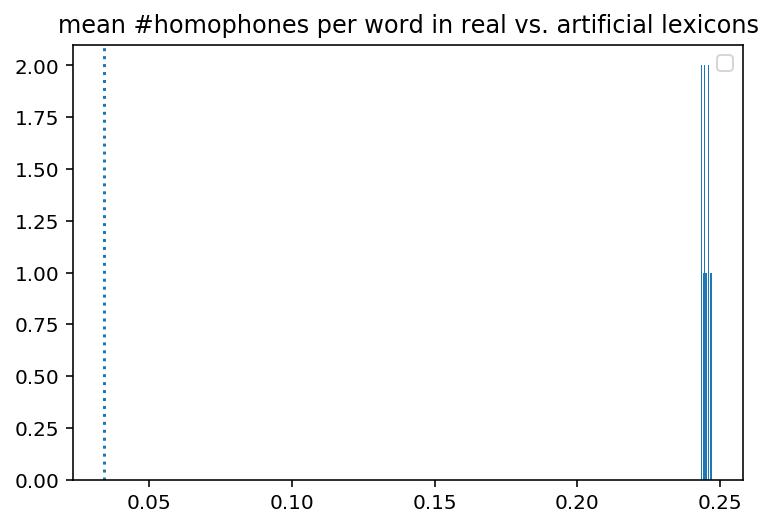

In [139]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


No handles with labels found to put in legend.


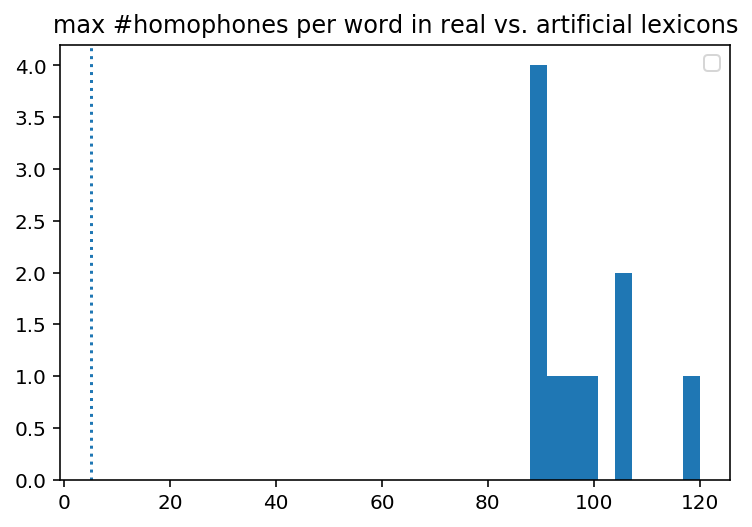

In [140]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### Distribution of homophones

In [141]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

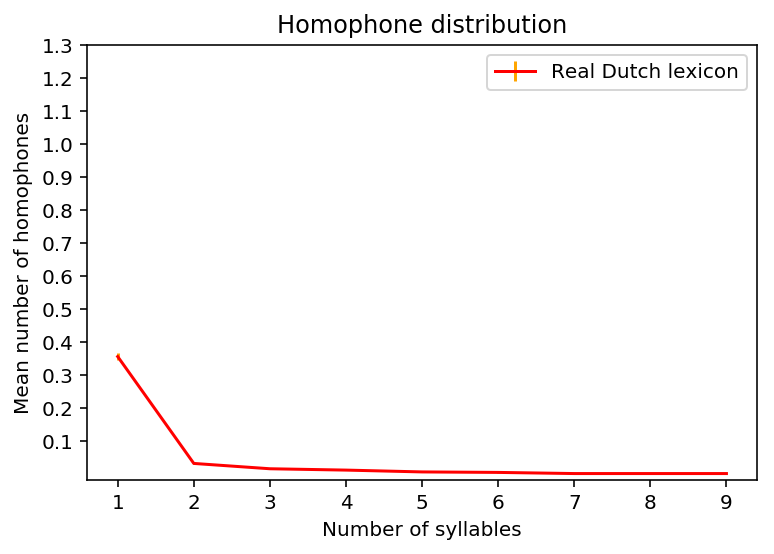

In [142]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Dutch lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.3])
plt.legend(loc='upper right')

In [143]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

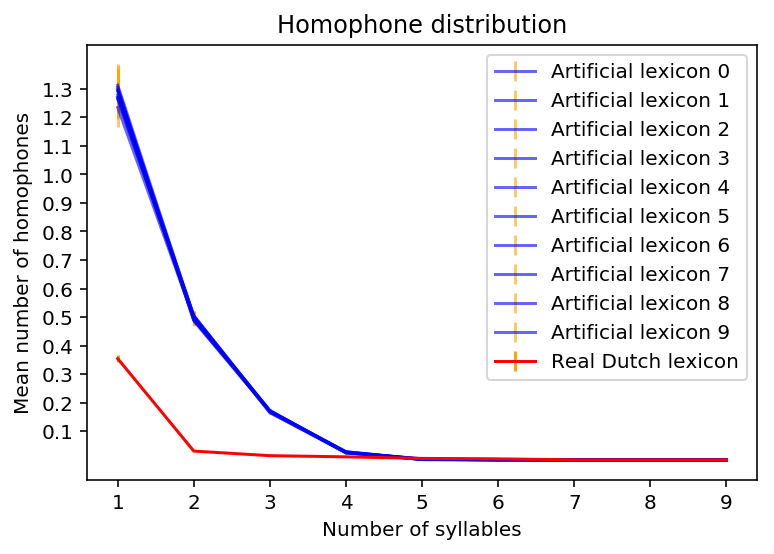

In [144]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Dutch lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.3])
plt.legend(loc='upper right')

### Statistics

In [145]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

In [146]:
slope_coefs = []
surprisal_coefs_dutch = []
for df_tmp_processed in tqdm(processed_artificials):    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_dutch.append(result.params['surprisal'])

100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


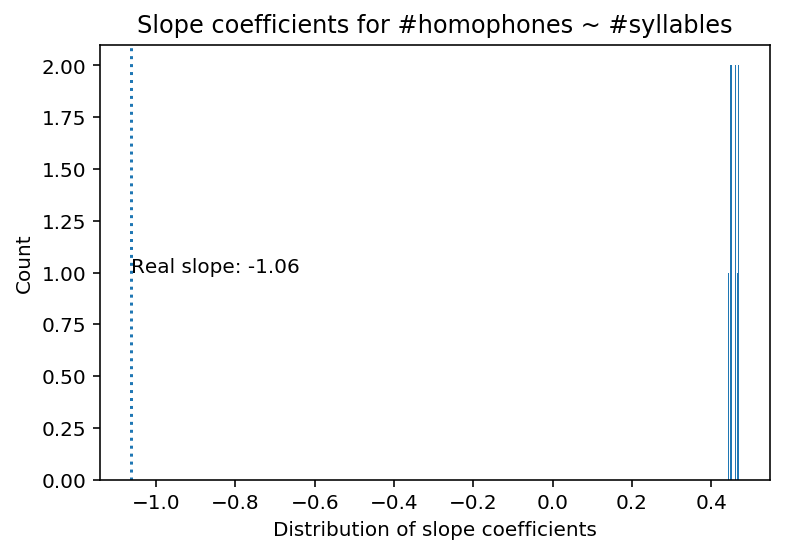

In [147]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

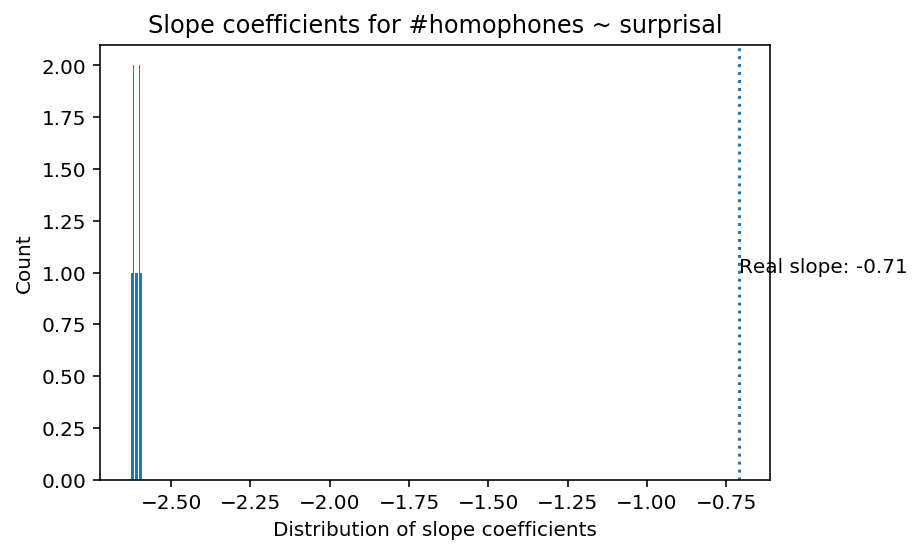

In [148]:
plt.hist(surprisal_coefs_dutch)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## French

### Real lexicon

In [149]:
df_celex_og = pd.read_csv("data/processed/french/french_all_reals.csv")

In [150]:
df_celex_og = pd.read_csv("data/processed/french/french_all_reals.csv")

In [151]:
len(df_celex_og)

47310

In [152]:
df_celex_processed = pd.read_csv("data/processed/french/french_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,...,32_old20,33_pld20,34_morphoder,35_nbmorph,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,0,a,a,a,NOM,m,NaN,81.36,58.65,...,1.00,1.00,a,1,1,1,False,4,-4.567200,4.567200
1,1,13,aa,aa,aa,NOM,m,s,0.01,0.00,...,1.00,1.00,aa,1,2,2,False,1,-4.605530,4.605530
2,2,17,abaca,abaka,abaca,NOM,m,s,0.01,0.00,...,2.00,1.90,abaca,1,5,3,False,0,-5.450975,5.450975
3,3,22,abaissant,abEs@,abaissant,ADJ,m,s,0.04,0.27,...,1.75,1.45,a-baissant,2,5,3,False,0,-5.174444,5.174444
4,4,25,abaisse,abEs,abaisse,NOM,f,s,0.02,0.00,...,1.60,1.40,a-baisser,2,4,2,False,0,-4.564642,4.564642


In [153]:
len(df_celex_processed)

37278

In [154]:
REAL_FRENCH_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_FRENCH_PERCENTAGE

0.14340898116851764

### Compare to artificial lexicons

In [155]:
NUM_ARTIFICIAL = 10

In [156]:
df_french_artificial = pd.read_csv("data/processed/french/french_artificial_10_matched_on_sylls_no_restriction.csv")


In [157]:
len(df_french_artificial)

473100

In [158]:
df_french_artificial['lexicon'] = df_french_artificial['lexicon'].apply(lambda x: str(x))

#### Phonotactics

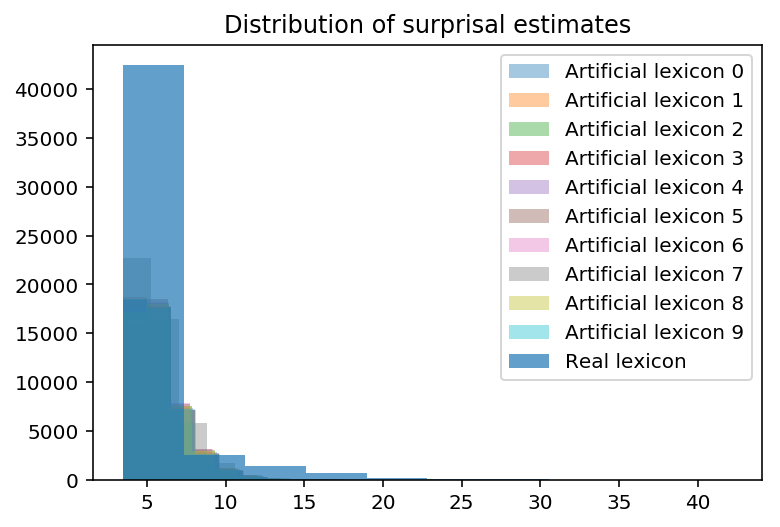

In [159]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_french_artificial[df_french_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

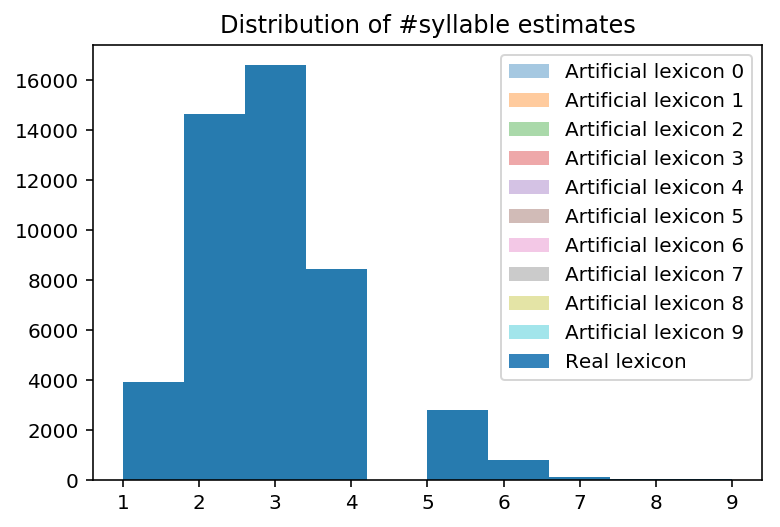

In [160]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_french_artificial[df_french_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of #syllable estimates")
plt.legend()

## Homophones

### Comparing percentage, mean, and max of homophones

In [161]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_french_artificial[df_french_artificial['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


 40%|████      | 4/10 [00:02<00:04,  1.37it/s]/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


No handles with labels found to put in legend.


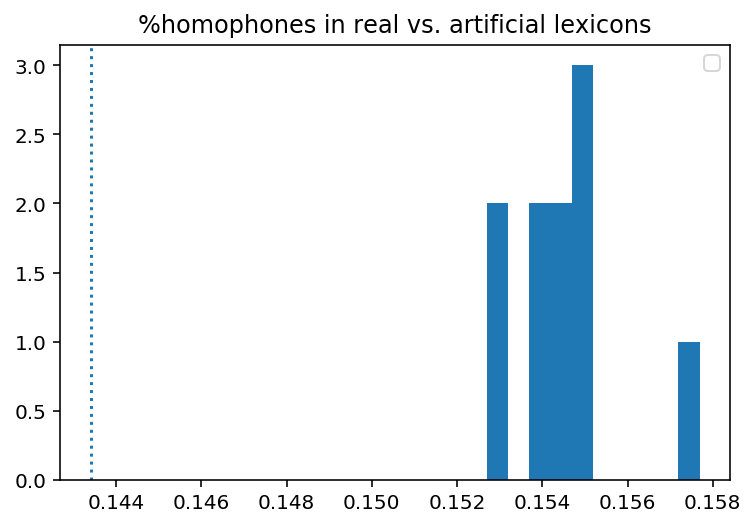

In [162]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_FRENCH_PERCENTAGE, linestyle="dotted")


No handles with labels found to put in legend.


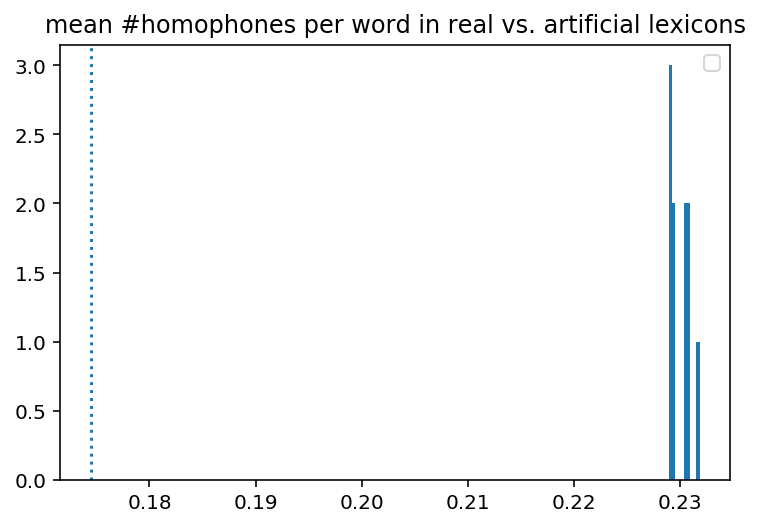

In [163]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


No handles with labels found to put in legend.


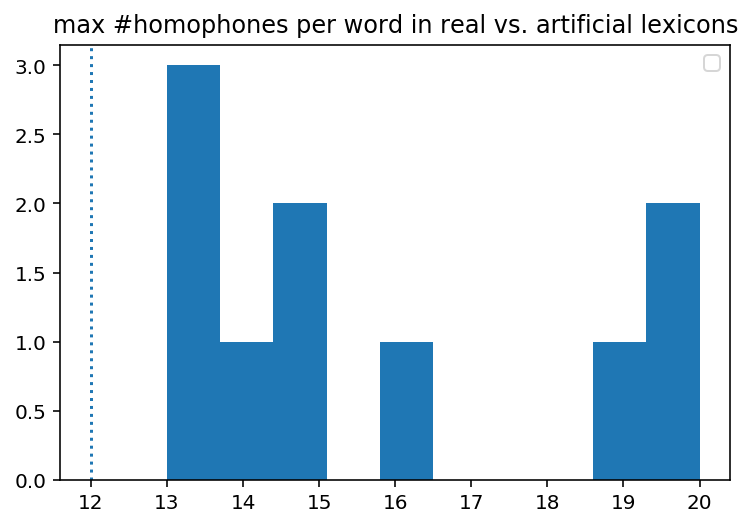

In [164]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### Distribution of homophones

In [165]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

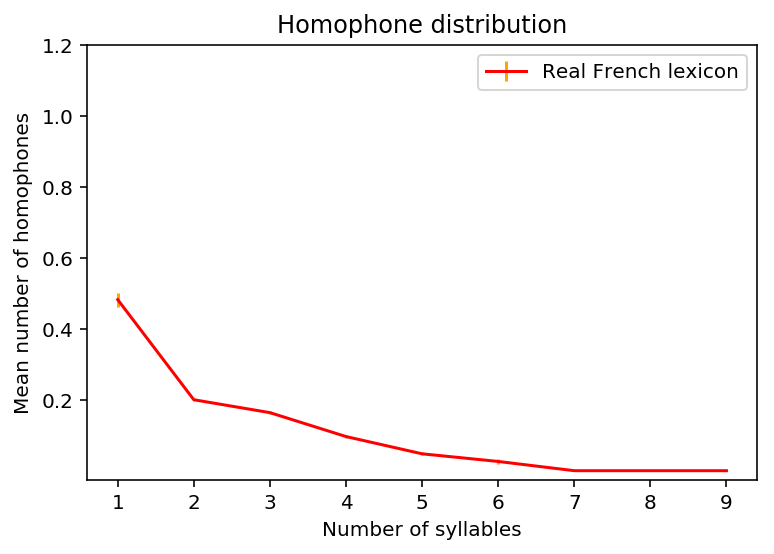

In [166]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real French lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.2, .4, .6, .8, 1, 1.2])
plt.legend(loc='upper right')

In [167]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

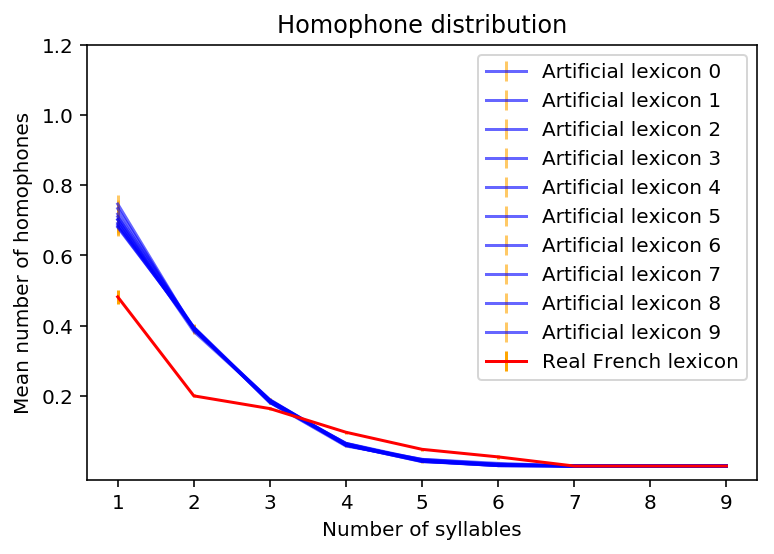

In [168]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real French lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.2, .4, .6, .8, 1, 1.2])
plt.legend(loc='upper right')

### Statistics

In [169]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

In [170]:
slope_coefs = []
surprisal_coefs_french = []
for df_tmp_processed in tqdm(processed_artificials):    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_french.append(result.params['surprisal'])

100%|██████████| 10/10 [00:01<00:00,  9.13it/s]


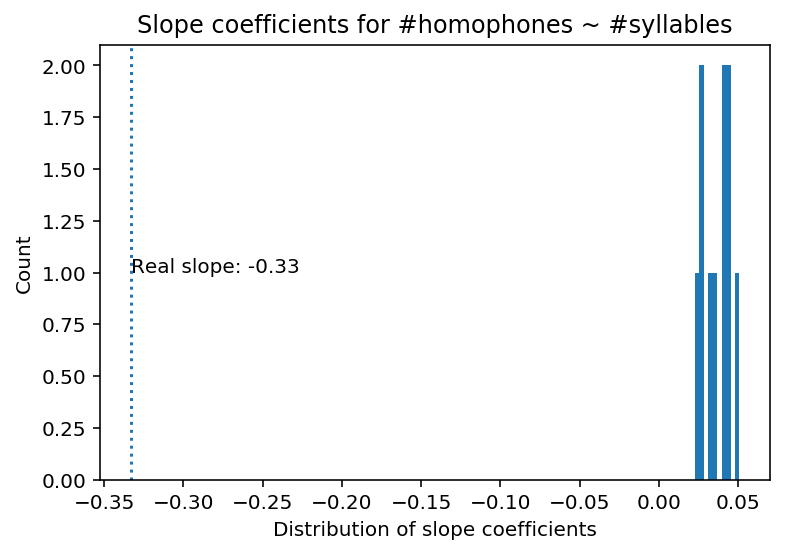

In [171]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

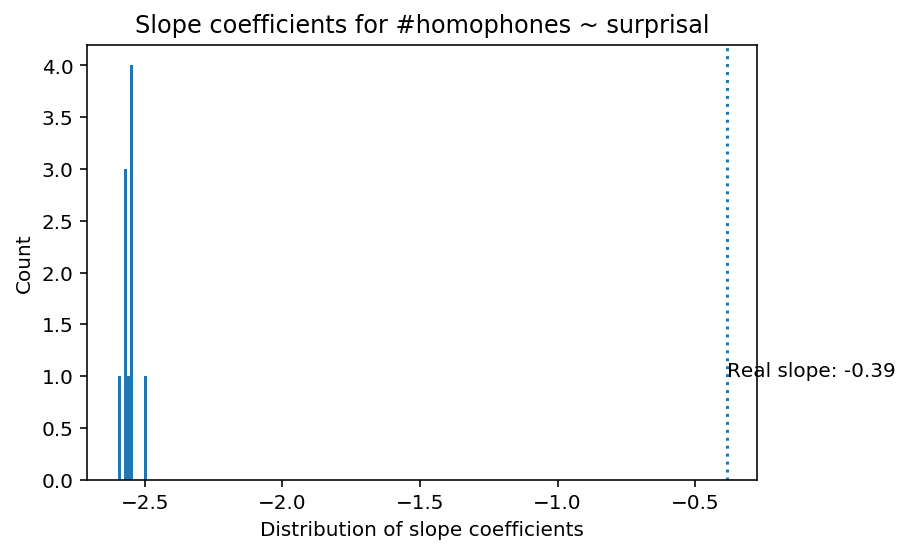

In [172]:
plt.hist(surprisal_coefs_french)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## Japanese

### Real lexicon

In [67]:
df_celex_og = pd.read_csv("data/processed/japanese/japanese_all_reals.csv")

In [68]:
len(df_celex_og)

51147

In [69]:
df_celex_processed = pd.read_csv("data/processed/japanese/japanese_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,Unnamed: 0.1,orth_form_kanji,orth_form_hiragana,orth_form_romaji,phonetic_form,morph_form,frequency,glosses,multiple_pronunications,phonetic_remapped,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,1,1,B,¤Ó¤¤,bii,bii,noun,16,/B/,False,bii,3,2,False,1,-4.615966,4.615966
1,1,4,4,E,¤¤¤¤,ii,ii,noun,126,/E/,False,ii,2,2,False,3,-4.605490,4.605490
2,2,5,5,F,¤¨¤Õ,efu,efu,noun,8,/F/,False,efu,3,2,False,1,-4.682481,4.682481
3,3,6,6,G,¤¸¤¤,jii,jii,noun,5,/G/,False,Ii,2,2,False,3,-4.613646,4.613646
4,4,7,7,H,¤¨¤¤¤Á,eichi,eiCi,noun,14,/H/,False,eiCi,4,3,False,0,-5.343851,5.343851


In [70]:
len(df_celex_processed)

40449

In [71]:
REAL_JAPANESE_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_JAPANESE_PERCENTAGE

0.15055996439961433

### Compare to artificial lexicons

In [72]:
NUM_ARTIFICIAL = 10

In [75]:
df_japanese_artificial = pd.read_csv("data/processed/japanese/japanese_artificial_10_matched_on_sylls_no_restriction.csv")


In [76]:
len(df_japanese_artificial)

511470

In [77]:
df_japanese_artificial['lexicon'] = df_japanese_artificial['lexicon'].apply(lambda x: str(x))

#### Phonotactics

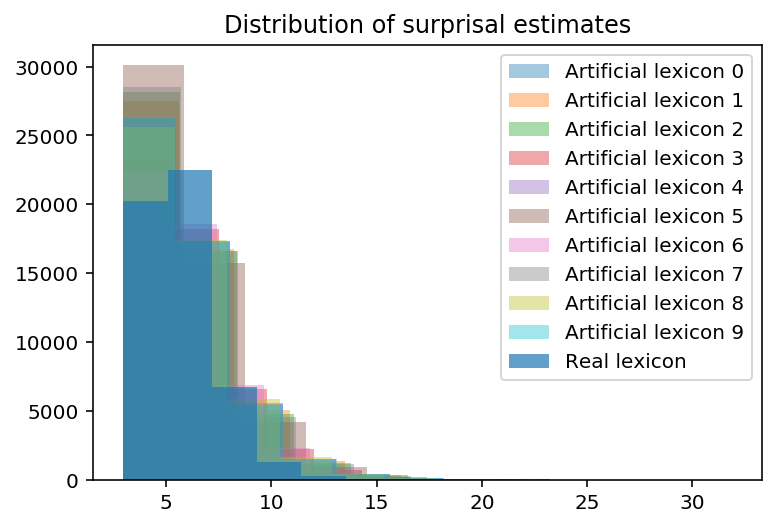

In [78]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_japanese_artificial[df_japanese_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

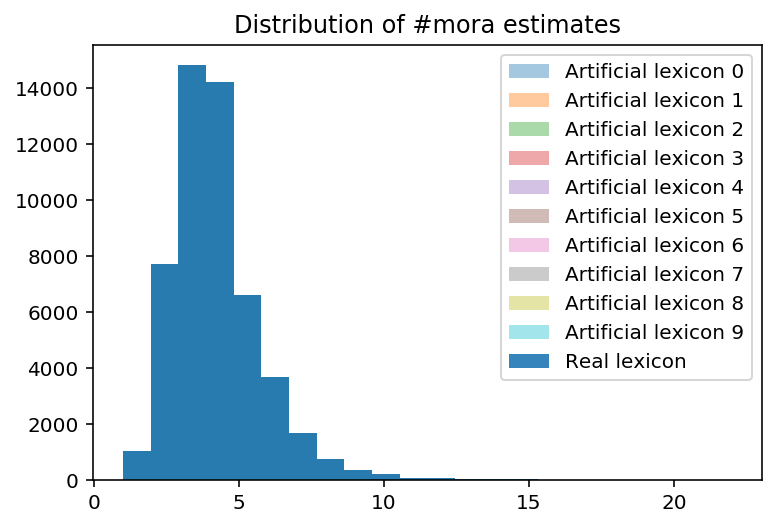

In [79]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_japanese_artificial[df_japanese_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, 
             label = "Artificial lexicon {x}".format(x=i),
             bins=22)

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .9, label = "Real lexicon".format(x=i), bins=22)
plt.title("Distribution of #mora estimates")
plt.legend()

## Homophones

### Comparing percentage, mean, and max of homophones

In [80]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_japanese_artificial[df_japanese_artificial['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


100%|██████████| 10/10 [00:07<00:00,  1.44it/s]


No handles with labels found to put in legend.


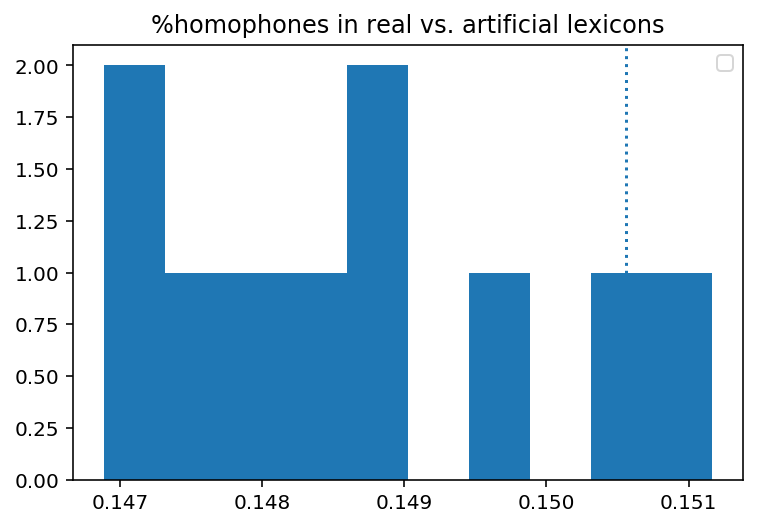

In [81]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_JAPANESE_PERCENTAGE, linestyle="dotted")


No handles with labels found to put in legend.


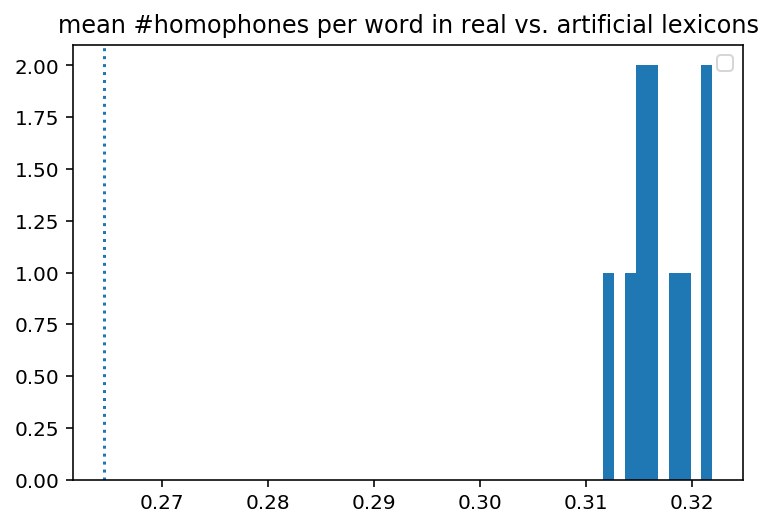

In [82]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


No handles with labels found to put in legend.


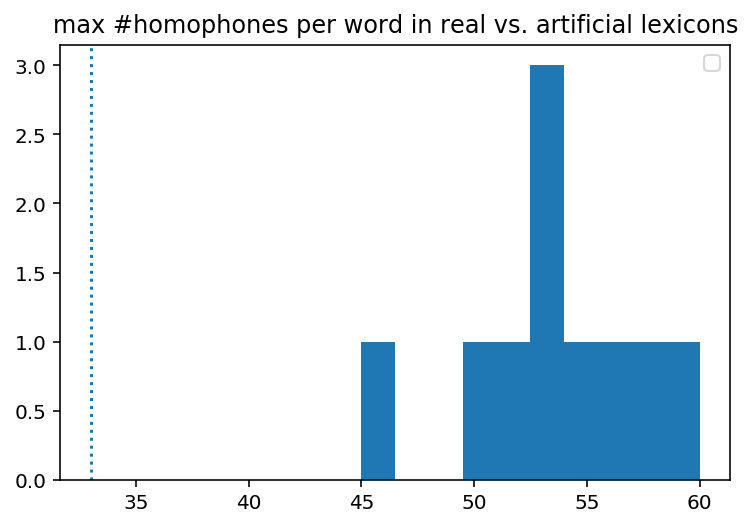

In [83]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


In [84]:
utils.get_homophone_stats(df_celex_processed)

{'homophone_percentage': 0.1506,
 'mean_homophones': 0.2645,
 'max_homophones': 33}

##### Distribution of homophones

In [85]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


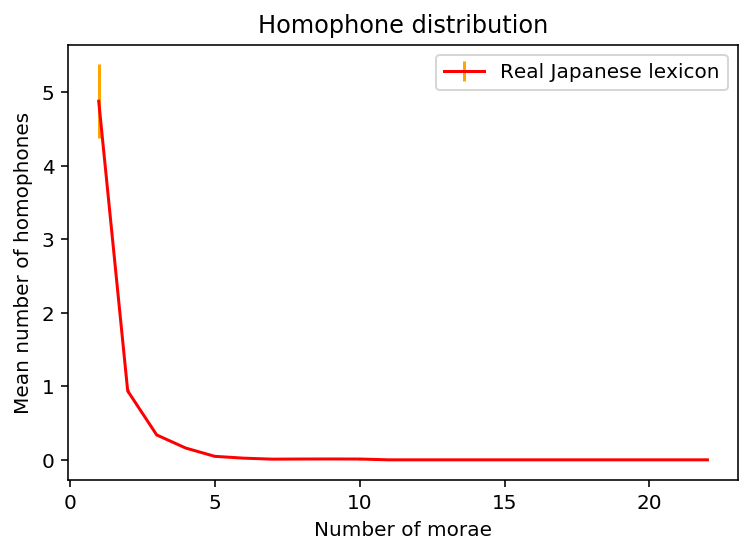

In [86]:
plt.title("Homophone distribution")
plt.xlabel("Number of morae")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Japanese lexicon")
# plt.xticks(list(range(1, 10)))
# plt.yticks([.2, .4, .6, .8, 1, 1.2])
plt.legend(loc='upper right')

In [87]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

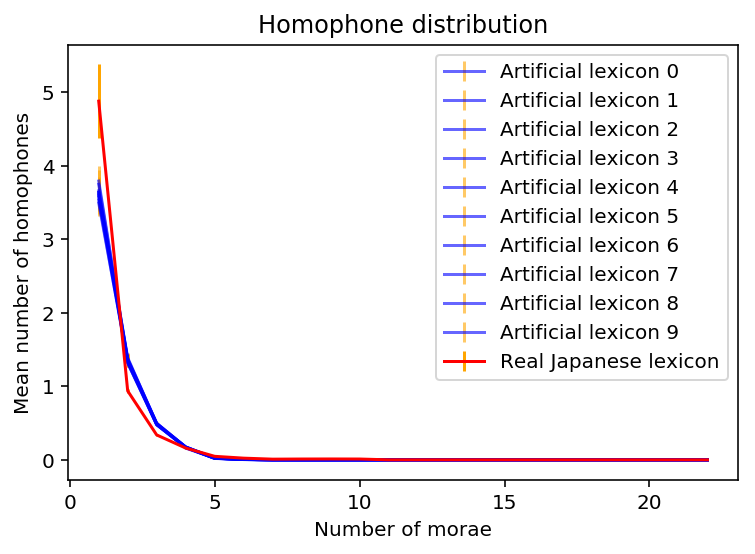

In [88]:
plt.title("Homophone distribution")
plt.xlabel("Number of morae")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Japanese lexicon")
# plt.xticks(list(range(1, 10)))
# plt.yticks([.2, .4, .6, .8, 1, 1.2])
plt.legend(loc='upper right')

### Statistics

In [89]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

In [90]:
slope_coefs = []
surprisal_coefs_french = []
for df_tmp_processed in tqdm(processed_artificials):    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_french.append(result.params['surprisal'])

100%|██████████| 10/10 [00:01<00:00,  9.12it/s]


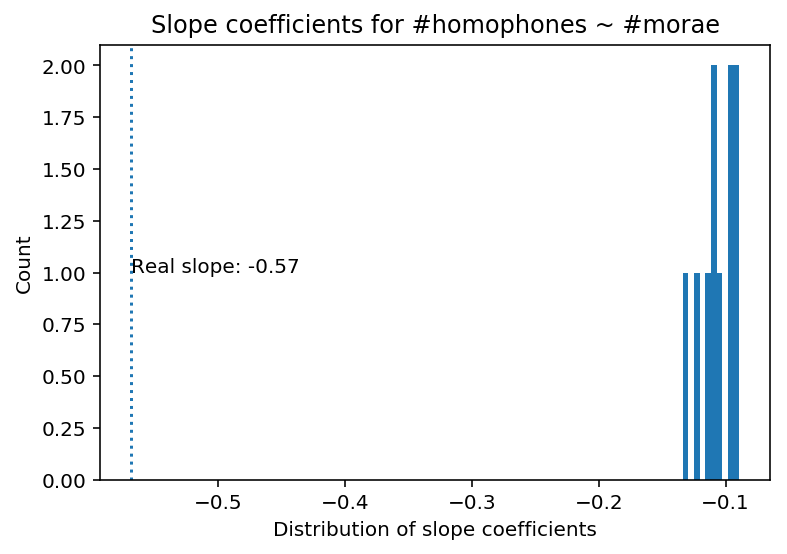

In [91]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #morae")
# plt.legend(loc='upper right')
plt.show()

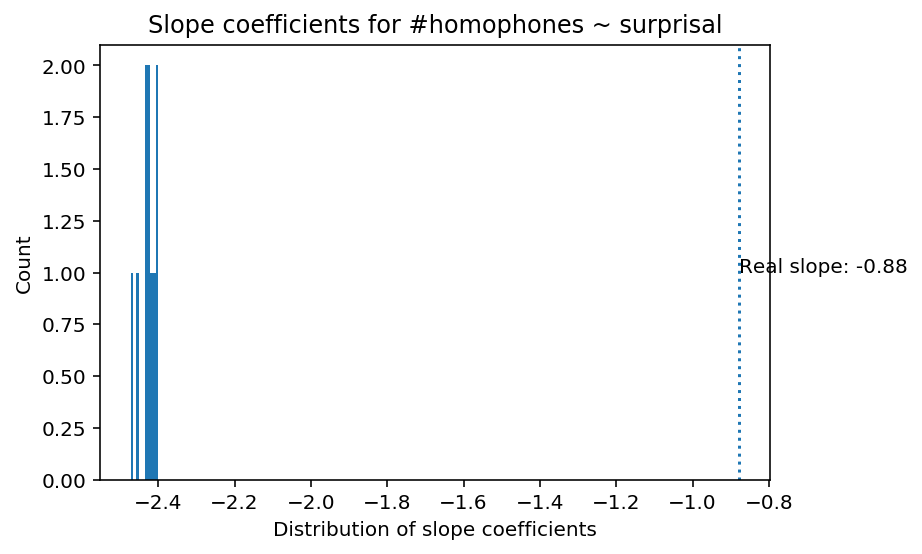

In [92]:
plt.hist(surprisal_coefs_french)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()